In [1]:
!wget https://apps.ml.jku.at/challenge/data/datasets/cell_id/images_test.tar
!wget https://apps.ml.jku.at/challenge/data/datasets/cell_id/images_train.tar
!wget https://apps.ml.jku.at/challenge/data/datasets/cell_id/y_train.csv

--2022-11-05 08:08:32--  https://apps.ml.jku.at/challenge/data/datasets/cell_id/images_test.tar
Resolving apps.ml.jku.at (apps.ml.jku.at)... 140.78.90.62
Connecting to apps.ml.jku.at (apps.ml.jku.at)|140.78.90.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68853760 (66M) [application/x-tar]
Saving to: ‘images_test.tar’

images_test.tar     100%[===================>]  65.66M  74.2MB/s    in 0.9s    

2022-11-05 08:08:33 (74.2 MB/s) - ‘images_test.tar’ saved [68853760/68853760]

--2022-11-05 08:08:33--  https://apps.ml.jku.at/challenge/data/datasets/cell_id/images_train.tar
Resolving apps.ml.jku.at (apps.ml.jku.at)... 140.78.90.62
Connecting to apps.ml.jku.at (apps.ml.jku.at)|140.78.90.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96706560 (92M) [application/x-tar]
Saving to: ‘images_train.tar’

images_train.tar    100%[===================>]  92.23M  78.6MB/s    in 1.2s    

2022-11-05 08:08:34 (78.6 MB/s) - ‘images_train.tar’ 

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

base_dir = './' 

data_dir = base_dir

# path_train = base_dir + 'images_train'
# path_test = base_dir + 'images_test'
path_train_labels = base_dir + 'y_train.csv'

In [ ]:
!mkdir images_test
!mkdir images_train
!tar -xvf 'images_train.tar' -C images_train
!tar -xvf 'images_test.tar' -C images_test 

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
classes = {'A549', 'CACO-2', 'HEK 293', 'HeLa', 'MCF7', 'PC-3', 'RT4', 'U-2 OS', 'U-251 MG'}
num_classes = len(classes)
path_train = "images_train/images_train" #"C:/Users/ASUS/Desktop/7ala - AI/AI in Life Sciences UE/Challenge 3/images_train/"
path_test = "images_test/images_test" #"C:/Users/ASUS/Desktop/7ala - AI/AI in Life Sciences UE/Challenge 3/images_test/"


In [5]:
from pathlib import Path, PurePath
import pandas as pd
from PIL import Image,ImageTk
import torchvision.models as models
import skimage.io as sk
import os
from sklearn.model_selection import train_test_split

In [6]:
train_labels = np.array(pd.read_csv(path_train_labels))
train_IDs = train_labels[:,0]
train_label = train_labels[:,1]
len(train_IDs)

9632

In [7]:
test_ids = []
for img_filename in os.listdir(path_test):
    if img_filename.endswith(".png"):
        ids = img_filename.split('_')[0]
        test_ids.append(ids)

In [8]:
import cv2
train_imgs = []
for ID in train_IDs:
        path_red = f'{path_train}/{str(ID).zfill(5)}_red.png'
        path_blue = f'{path_train}/{str(ID).zfill(5)}_blue.png'
        path_yellow = f'{path_train}/{str(ID).zfill(5)}_yellow.png'
        
        image_red = cv2.imread(path_red,0)
        image_blue = cv2.imread(path_blue,0)
        image_yellow = cv2.imread(path_yellow,0)
        images = [image_red,image_blue, image_yellow]
        input_image = np.stack(images, axis=-1)
        train_imgs.append(input_image)
test_imgs = []
for ID in test_ids:
        path_red = f'{path_test}/{str(ID).zfill(5)}_red.png'
        path_blue = f'{path_test}/{str(ID).zfill(5)}_blue.png'
        path_yellow = f'{path_test}/{str(ID).zfill(5)}_yellow.png'
        
        image_red = cv2.imread(path_red,0)
        image_blue = cv2.imread(path_blue,0)
        image_yellow = cv2.imread(path_yellow,0)
        images = [image_red,image_blue, image_yellow]
        input_image = np.stack(images, axis=-1)
        test_imgs.append(input_image)
        

In [9]:
image_transforms = { 
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.Resize(size=224),
        transforms.RandomRotation(degrees=15),
        
        transforms.RandomHorizontalFlip(),
        #transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=224),
        #transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
     'test': transforms.Compose([
        transforms.Resize(size=224),
        #transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, ids_and_labels, rootDir, sourceTransform):
        self.ids = ids_and_labels[:,0]
#         print(len(self.ids))
        self.data_labels = ids_and_labels[:,1]
#         print(self.data_labels)
        self.rootDir = rootDir
        self.sourceTransform = sourceTransform
        train_imgs = []
        for ID in self.ids: #train_IDs:
            path_red = f'{self.rootDir}/{str(ID).zfill(5)}_red.png'
            path_blue = f'{self.rootDir}/{str(ID).zfill(5)}_blue.png'
            path_yellow = f'{self.rootDir}/{str(ID).zfill(5)}_yellow.png'

            image_red = cv2.imread(path_red,0)
            image_blue = cv2.imread(path_blue,0)
            image_yellow = cv2.imread(path_yellow,0)
            images = [image_red,image_blue, image_yellow]
            input_image = np.stack(images, axis=-1)
            train_imgs.append(input_image)
#         plt.imshow(train_imgs[0])
        self.train_imgs = train_imgs
#         print("hi",len(self.train_imgs))
        return

    def __len__(self):
        return int(len(self.data_labels))
    
    def one_hot_encode(self, label):
        
        self.classes = ['A549', 'CACO-2', 'HEK 293', 'HeLa', 'MCF7', 'PC-3', 'RT4', 'U-2 OS', 'U-251 MG']
        mapping = {}
        for x in range(len(self.classes)):
            mapping[self.classes[x]] = x
        '''
        onehot_encoded = []
        #for value in label:
        arr = list(np.zeros(len(self.classes), dtype = int))
        arr[mapping[label]] = 1
        #onehot_encoded.append(arr)
        '''
        return torch.tensor(mapping[label])
        #return torch.tensor(arr)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()                
        label = self.one_hot_encode(self.data_labels[idx])
        image = Image.fromarray(self.train_imgs[idx])
        
        if self.sourceTransform:
            image = self.sourceTransform(image)
        return image, label

In [11]:
train_labels1 = train_labels[:7890,:] #[:,0]
valid_labels = train_labels[7890:,:] #[:,0]

train_trainset = CustomDataset(train_labels1, path_train, image_transforms['train'])
valid_trainset = CustomDataset(valid_labels, path_train, image_transforms['valid'])
# test_trainset = CustomDataset(valid_labels, path_train, image_transforms['test'])

train_data_loader = DataLoader(train_trainset, batch_size=32, shuffle=True, num_workers=2)
valid_data_loader = DataLoader(valid_trainset, batch_size=32, shuffle=False, num_workers=2)

1742

In [12]:
import torch.nn as nn
import torchvision


In [55]:
class EfficientNetB0(nn.Module):
    def __init__(self, n_units_out):
        super(EfficientNetB0, self).__init__()
        self.model = torchvision.models.efficientnet_b0(pretrained=True)
        
        self.model.classifier = nn.Sequential(nn.Dropout(p=0.65, inplace=True),
                                              nn.Linear(in_features=1280, out_features=n_units_out, bias=True))
    def forward(self, x):
        x = self.model.features(x)

        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.model.classifier(x)
        return x

    def get_features(self,x):
        x = self.model.features(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        return x

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

In [56]:
model = EfficientNetB0(9)
if torch.cuda.is_available():
    model = model.cuda()

train_data_size = len(train_data_loader)
valid_data_size = len(valid_data_loader)
#train_data_size = len(valid_data_loader)
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    history = []
    best_acc = 0.0
    
    features_ep = []
    for epoch in range(epochs):
        '''
        if epoch >= 5:
            for param in model.parameters():
                param.requires_grad = True
        '''
        print("Epoch: {}/{}".format(epoch+1, epochs))        
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_data_loader,0):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)            
            loss = loss_criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            train_acc += accuracy(outputs, labels)

        # Validation - No gradient tracking needed
        with torch.no_grad():
            model.eval()

            # Validation loop
            features = None
            for j, (inputs, labels) in enumerate(valid_data_loader,0):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)

                output_features = model.get_features(inputs)
                current_features = output_features.detach().cpu().numpy()
                
                if features is not None:
                    features = np.concatenate((features, current_features))
                else:
                    features = current_features
                
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                valid_acc += accuracy(outputs, labels)
        features_ep.append(features)   
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation Loss : {:.4f}, Accuracy: {:.4f}%".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100))

        # Save if the model has best accuracy till now
        torch.save(model, '_model_'+str(epoch)+'.pt')
            
    return model, history, np.array(features_ep)



In [57]:
import torch.optim as optim
loss_func = nn.CrossEntropyLoss().to(device) #torchvision.ops.sigmoid_focal_loss().to(device) #
num_epochs = 10
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
trained_model, history, features = train_and_validate(model, loss_func, optimizer, num_epochs)

Epoch: 1/10
Epoch : 001, Training: Loss: 66.5256, Accuracy: 21.5081%, 
		Validation Loss : 53.7138, Accuracy: 47.5974%
Epoch: 2/10
Epoch : 002, Training: Loss: 46.8865, Accuracy: 52.3097%, 
		Validation Loss : 33.0588, Accuracy: 69.5049%
Epoch: 3/10
Epoch : 003, Training: Loss: 29.6757, Accuracy: 70.4875%, 
		Validation Loss : 19.3330, Accuracy: 81.5828%
Epoch: 4/10
Epoch : 004, Training: Loss: 19.0975, Accuracy: 80.8761%, 
		Validation Loss : 12.4791, Accuracy: 87.4919%
Epoch: 5/10
Epoch : 005, Training: Loss: 13.6420, Accuracy: 86.3290%, 
		Validation Loss : 8.7447, Accuracy: 91.4854%
Epoch: 6/10
Epoch : 006, Training: Loss: 10.2610, Accuracy: 89.3050%, 
		Validation Loss : 7.4910, Accuracy: 92.7841%
Epoch: 7/10
Epoch : 007, Training: Loss: 7.9408, Accuracy: 91.9914%, 
		Validation Loss : 6.1020, Accuracy: 93.8636%
Epoch: 8/10
Epoch : 008, Training: Loss: 6.2454, Accuracy: 93.6994%, 
		Validation Loss : 5.7447, Accuracy: 94.1883%
Epoch: 9/10
Epoch : 009, Training: Loss: 5.4271, Accur

In [58]:
colors_per_class = {
    'A549' : [254, 202, 87],
    'CACO-2' : [255, 107, 107],
    'HEK 293' : [10, 189, 227],
    'HeLa' : [255, 159, 243],
    'MCF7' : [16, 172, 132],
    'PC-3' : [128, 80, 128],
    'RT4' : [87, 101, 116],
    'U-2 OS' : [52, 31, 151],
    'U-251 MG' : [100, 100, 255],
    #'9' : [100, 100, 255],
}


In [59]:
features.shape

(10, 1742, 1280)

In [40]:
from sklearn.manifold import TSNE

In [60]:
tsne = TSNE(2, verbose=1,n_jobs=-1).fit_transform(features[-1])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1742 samples in 0.002s...
[t-SNE] Computed neighbors for 1742 samples in 0.382s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1742
[t-SNE] Computed conditional probabilities for sample 1742 / 1742
[t-SNE] Mean sigma: 4.925843
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.424465
[t-SNE] KL divergence after 1000 iterations: 0.921380


In [61]:
tsne_1 = TSNE(2, verbose=1,n_jobs=-1).fit_transform(features[0])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1742 samples in 0.005s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 1742 samples in 0.374s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1742
[t-SNE] Computed conditional probabilities for sample 1742 / 1742
[t-SNE] Mean sigma: 2.771162
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.491547
[t-SNE] KL divergence after 1000 iterations: 1.894910


In [43]:
classes = ['A549', 'CACO-2', 'HEK 293', 'HeLa', 'MCF7', 'PC-3', 'RT4', 'U-2 OS', 'U-251 MG']
decode = {}
for x in range(len(classes)):
    decode[x] = classes[x]

In [44]:
images =[]
labels =[]
for i in range(len(valid_trainset)):
  
  image = valid_trainset[i][0].numpy()[0]
  label = valid_trainset[i][1].numpy()
  images.append(image)
  labels.append(decode[int(label)])

In [45]:
import cv2

def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range


def scale_image(image, max_image_size):
    image_height, image_width = image.shape

    scale = max(1, image_width / max_image_size, image_height / max_image_size)
    image_width = int(image_width / scale)
    image_height = int(image_height / scale)

    image = cv2.resize(image, (image_width, image_height))
    return image


def draw_rectangle_by_class(image, label):
    image_height, image_width = image.shape
    print(label)
    # get the color corresponding to image class
    color = colors_per_class[label]
    image = cv2.rectangle(image, (0, 0), (image_width - 1, image_height - 1), color=color, thickness=5)

    return image

In [29]:
def compute_plot_coordinates(image, x, y, image_centers_area_size, offset):
    image_height, image_width = image.shape

    # compute the image center coordinates on the plot
    center_x = int(image_centers_area_size * x) + offset

    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int(image_centers_area_size * (1 - y)) + offset

    # knowing the image center, compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)

    br_x = tl_x + image_width
    br_y = tl_y + image_height

    return tl_x, tl_y, br_x, br_y

In [34]:
from tqdm import tqdm
def visualize_tsne_points(tx, ty, labels):
    # initialize matplotlib plot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    # for every class, we'll add a scatter plot separately
    for label in colors_per_class:
        # find the samples of the current class in the data
        indices = [i for i, l in enumerate(labels) if l == label]

        # extract the coordinates of the points of this class only
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)

        # convert the class color to matplotlib format:
        # BGR -> RGB, divide by 255, convert to np.array
        color = np.array([colors_per_class[label][::-1]], dtype=np.float) / 255

        # add a scatter plot with the correponding color and label
        ax.scatter(current_tx, current_ty, c=color, label=label)

    # build a legend using the labels we set previously
    ax.legend(loc='best')

    # finally, show the plot
    plt.show()

def visualize_tsne_images(tx, ty, images, labels, plot_size=1000, max_image_size=100):
    # we'll put the image centers in the central area of the plot
    # and use offsets to make sure the images fit the plot
    offset = max_image_size // 2
    image_centers_area_size = plot_size - 2 * offset

    tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8)

    # now we'll put a small copy of every image to its corresponding T-SNE coordinate
    for img, label, x, y in tqdm(
            zip(images, labels, tx, ty),
            desc='Building the T-SNE plot',
            total=len(images)
    ):
        image = img

        # scale the image to put it to the plot
        image = scale_image(image, max_image_size)

        # draw a rectangle with a color corresponding to the image class
        image = draw_rectangle_by_class(image, label)

        # compute the coordinates of the image on the scaled plot visualization
        tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size, offset)

        # put the image to its TSNE coordinates using numpy subarray indices
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image

    plt.imshow(tsne_plot[:, :, ::-1])
    plt.show()

In [31]:
def visualize_tsne(tsne, images, labels, plot_size=1000, max_image_size=100):
    # extract x and y coordinates representing the positions of the images on T-SNE plot
    tx = tsne[:, 0]
    ty = tsne[:, 1]

    # scale and move the coordinates so they fit [0; 1] range
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)

    # visualize the plot: samples as colored points
    visualize_tsne_points(tx, ty, labels)

    # visualize the plot: samples as images
    #visualize_tsne_images(tx, ty, images, labels, plot_size=plot_size, max_image_size=max_image_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


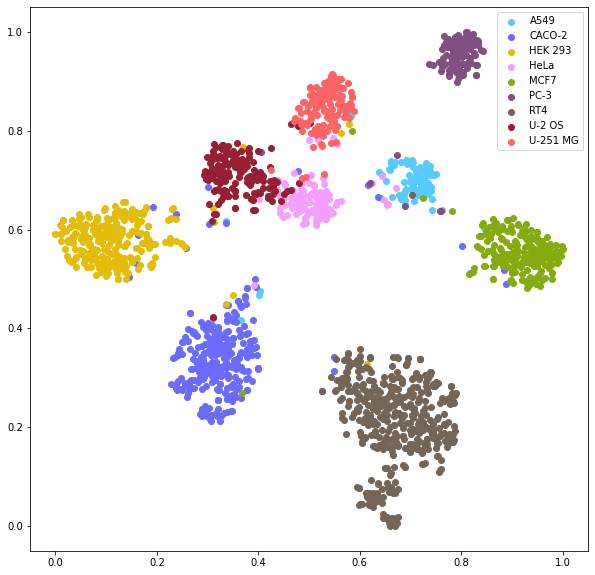

In [62]:

import matplotlib.pyplot as plt
visualize_tsne(tsne, images, labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


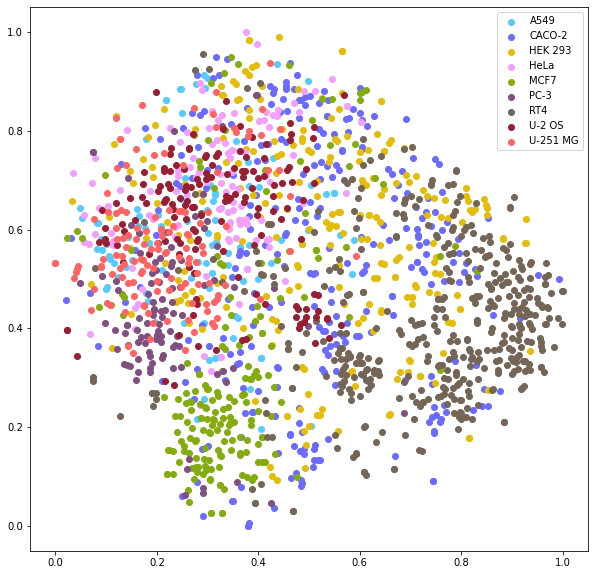

In [63]:
import matplotlib.pyplot as plt
visualize_tsne(tsne_1, images, labels)

In [65]:
features.shape

(10, 1742, 1280)

In [64]:
from numpy import savez_compressed
# define data

# save to npy file
savez_compressed('features.npz', features)

In [50]:
np.save('features.npy',features)